In [8]:
import pybamm
import numpy as np
import pandas as pd
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from SALib.plotting.bar import plot as barplot
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [67]:
# 创建DFN模型
model = pybamm.lithium_ion.DFN()

# 创建实验
experiment = pybamm.Experiment(
    ["Rest for 901 s",
        "Discharge at 0.96 A for 147 s",
        "Rest for 361 s",
        "Discharge at 0.96 A for 134 s"
    ]
)

# 设置参数
param = pybamm.ParameterValues("OKane2022")
# param = model.default_parameter_values
param["Initial concentration in negative electrode [mol.m-3]"] = 0.9*param["Maximum concentration in negative electrode [mol.m-3]"]
# param["Initial concentration in positive electrode [mol.m-3]"] = 0.5*param["Maximum concentration in positive electrode [mol.m-3]"]

# 创建仿真对象
solver = pybamm.CasadiSolver(
        mode="safe",
        atol=1e-8,
        rtol=1e-8,
        dt_max=1e-2
    )
simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)

# 运行仿真
solution = simulation.solve(calc_esoh=False)

# 获取结果
time = solution["Time [s]"].entries
voltage = solution["Terminal voltage [V]"].entries

if time[0] != 0:
    time = np.insert(time, 0, 0)
    voltage = np.insert(voltage, 0, voltage[0])

time_new = np.arange(0, int(time[-1]) + 1)  # 创建一个从0到最后时间的每秒数组
interp_func = interp1d(time, voltage, kind='linear', fill_value="extrapolate")
voltage_new = interp_func(time_new)  # 对每秒进行插值

In [68]:
df_ex = pd.read_csv('data/data_ocv_ex.csv')
df_ex_6115 = df_ex.head(1544)
voltage_ex = df_ex_6115['Voltage[V]']

In [69]:
# Calculating MSE
mse = mean_squared_error(voltage_ex, voltage_new)
print(f'MSE: {mse}')

MSE: 0.0001752830039346147


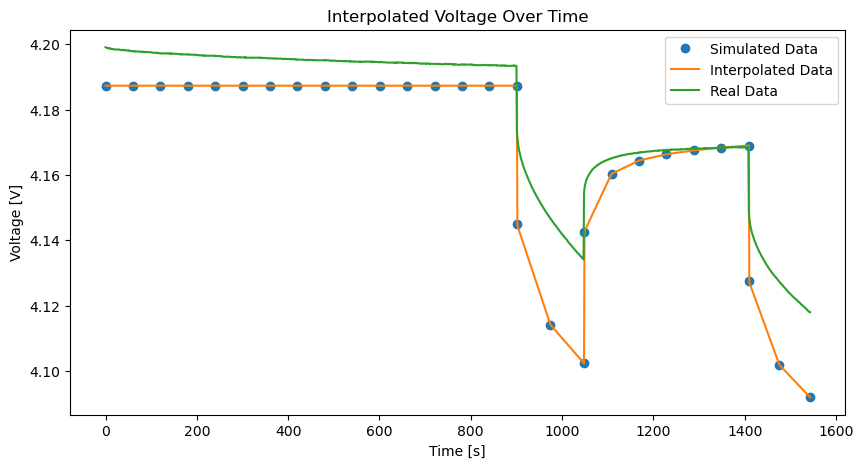

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(time, voltage, 'o', label='Simulated Data')
plt.plot(time_new, voltage_new, '-', label='Interpolated Data')
plt.plot(time_new, voltage_ex, '-', label='Real Data')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.title('Interpolated Voltage Over Time')
plt.legend()
plt.show()

In [29]:
param

{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.2594,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 5.0,
 'Dead lithium decay constant [s-1]': 1e-06,
 'Dead lithium decay rate [s-1]': <function SEI_limited_dead_lithium_OKane2022 at 0x00000266ADF17BA0>,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Nyman2008_arrhenius at 0x00000266AFD5EAC0>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Nyman2008_arrhenius at 0x00000266AFD5F560>,
 'Electron charge [C]': 1.602176634e-19,
 'Exchange-current density for plating [A.m-2]': <function 

In [ ]:
 'Initial concentration in negative electrode [mol.m-3]': 29866.0,
 'Initial concentration in positive electrode [mol.m-3]': 17038.0,
 'Maximum concentration in negative electrode [mol.m-3]': 33133.0,
 'Maximum concentration in positive electrode [mol.m-3]': 63104.0,
